# Sentiment Analysis with Word Embeddings and Neural Network

In this exercise we use a powerful method, word embedding, to represent word in the numerical way and apply it to a simply 2-layer network for sentiment classification of emoji data.


**Pipeline**

<img src="resources/pipeline.png" width="800px">

In [2]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import utils and set plt settings
import utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

## Word Embedding

<img src="resources/word-vector.png" width="800">

### Emoji Classifier

<img src="resources/emoji.png" width="800">

In [6]:
train_x, test_x, train_y, test_y = utils.load_emoji()

In [7]:
# Download and load word embeddings
# This util function returns two dict: word_to_index and word_to_vec
# At this moment, we only need the second part
_, word_to_vec_map = utils.load_glove_vecs()

data already available, skip downloading.
loading glove... this may take a while...
glove loaded successfully.


In [8]:
word_to_vec_map['love']

array([-0.13886  ,  1.1401   , -0.85212  , -0.29212  ,  0.75534  ,
        0.82762  , -0.3181   ,  0.0072204, -0.34762  ,  1.0731   ,
       -0.24665  ,  0.97765  , -0.55835  , -0.090318 ,  0.83182  ,
       -0.33317  ,  0.22648  ,  0.30913  ,  0.026929 , -0.086739 ,
       -0.14703  ,  1.3543   ,  0.53695  ,  0.43735  ,  1.2749   ,
       -1.4382   , -1.2815   , -0.15196  ,  1.0506   , -0.93644  ,
        2.7561   ,  0.58967  , -0.29473  ,  0.27574  , -0.32928  ,
       -0.201    , -0.28547  , -0.45987  , -0.14603  , -0.69372  ,
        0.070761 , -0.19326  , -0.1855   , -0.16095  ,  0.24268  ,
        0.20784  ,  0.030924 , -1.3711   , -0.28606  ,  0.2898   ])

In [9]:
len(word_to_vec_map)

400000

In [10]:
# Print the first 20 samples
for i in range(20):
    print(train_x[i], utils.label_to_emoji(train_y[i]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾
she did not answer my text  😞
Your stupidity has no limit 😞
how many points did he score ⚾
my algorithm performs poorly 😞
I got approved 😄
Stop shouting at me 😞
Sounds like a fun plan ha ha 😄
no one likes him 😞
the game just finished ⚾
I will celebrate soon 😄


In [11]:
# Convert output to one hot vector
train_y_oh = utils.convert_to_one_hot(train_y, 5)
test_y_oh = utils.convert_to_one_hot(test_y, 5)

print(train_y[9], "is converted into one hot", train_y_oh[9])

1 is converted into one hot [0. 1. 0. 0. 0.]


In [12]:
train_y[:3]

array([3, 2, 3])

In [13]:
train_y_oh[:3]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [14]:
avg = utils.sentence_to_avg("I like it", word_to_vec_map)
avg

array([ 0.36627333,  0.04672333, -0.138081  , -0.24937467,  0.48939667,
        0.04623667, -0.47231333, -0.14826667, -0.457185  ,  0.20397252,
       -0.10503   ,  0.60011667, -0.61682667, -0.1575    ,  0.78038333,
        0.55919   ,  0.29008333,  0.34581633, -0.22630233, -0.70794   ,
       -0.30531333,  0.34949667,  0.46258333,  0.234054  ,  0.63990667,
       -2.12683333, -1.06518   ,  0.45987   ,  0.74048667, -0.92987667,
        3.59586667,  0.33653667, -0.282609  , -0.01870267, -0.19816133,
       -0.202     ,  0.05308333,  0.35650667,  0.30246667, -0.23844333,
       -0.07741177,  0.226214  , -0.09908807,  0.37313   ,  0.06784867,
        0.37182667, -0.147618  , -0.43038933, -0.25390733,  0.44703333])

In [15]:
a = utils.sentence_to_avg("like", word_to_vec_map)
a

array([ 3.6808e-01,  2.0834e-01, -2.2319e-01,  4.6283e-02,  2.0098e-01,
        2.7515e-01, -7.7127e-01, -7.6804e-01, -3.4861e-01,  5.0620e-01,
       -2.4401e-01,  7.1775e-01, -3.3348e-01,  3.7554e-01,  4.4756e-01,
        3.6698e-01,  4.3533e-01,  4.7570e-01, -5.6113e-02, -9.3531e-01,
       -2.7591e-01,  3.1610e-01,  2.2116e-01,  3.6304e-01,  1.0757e-01,
       -1.7638e+00, -1.2624e+00,  3.0284e-01,  5.6286e-01, -1.0214e+00,
        3.2353e+00,  4.8483e-01,  2.7953e-02,  3.6082e-02, -7.8554e-02,
        1.8761e-01, -5.2573e-01,  3.7200e-02,  2.7579e-01, -7.7360e-02,
       -2.7955e-01,  7.9752e-01,  1.6028e-03,  4.5479e-01,  8.8382e-01,
        4.3893e-01, -1.9263e-01, -6.7236e-01, -3.9709e-01,  2.5183e-01])

In [16]:
b = utils.sentence_to_avg("me", word_to_vec_map)
b

array([-0.14525 ,  0.31265 ,  0.15184 , -0.63708 ,  0.63553 , -0.50295 ,
       -0.23214 ,  0.52892 , -0.58629 ,  0.53935 , -0.3055  ,  1.0357  ,
       -0.77989 , -0.19387 ,  1.2215  ,  0.24521 ,  0.26144 ,  0.22439 ,
        0.15584 , -0.79146 , -0.65262 ,  1.3211  ,  0.76618 ,  0.38234 ,
        1.4453  , -2.2643  , -1.1505  ,  0.50373 ,  1.2651  , -1.5903  ,
        3.0518  ,  0.84118 , -0.69543 ,  0.29985 , -0.49151 , -0.22312 ,
        0.59528 , -0.076347,  0.52358 , -0.50134 ,  0.22483 ,  0.01546 ,
       -0.088005,  0.21282 ,  0.28545 , -0.15976 , -0.16777 , -0.50895 ,
        0.14322 ,  1.0118  ])

In [17]:
c = utils.sentence_to_avg("me like", word_to_vec_map)
c

array([ 0.111415 ,  0.260495 , -0.035675 , -0.2953985,  0.418255 ,
       -0.1139   , -0.501705 , -0.11956  , -0.46745  ,  0.522775 ,
       -0.274755 ,  0.876725 , -0.556685 ,  0.090835 ,  0.83453  ,
        0.306095 ,  0.348385 ,  0.350045 ,  0.0498635, -0.863385 ,
       -0.464265 ,  0.8186   ,  0.49367  ,  0.37269  ,  0.776435 ,
       -2.01405  , -1.20645  ,  0.403285 ,  0.91398  , -1.30585  ,
        3.14355  ,  0.663005 , -0.3337385,  0.167966 , -0.285032 ,
       -0.017755 ,  0.034775 , -0.0195735,  0.399685 , -0.28935  ,
       -0.02736  ,  0.40649  , -0.0432011,  0.333805 ,  0.584635 ,
        0.139585 , -0.1802   , -0.590655 , -0.126935 ,  0.631815 ])

In [18]:
(a+b)/2

array([ 0.111415 ,  0.260495 , -0.035675 , -0.2953985,  0.418255 ,
       -0.1139   , -0.501705 , -0.11956  , -0.46745  ,  0.522775 ,
       -0.274755 ,  0.876725 , -0.556685 ,  0.090835 ,  0.83453  ,
        0.306095 ,  0.348385 ,  0.350045 ,  0.0498635, -0.863385 ,
       -0.464265 ,  0.8186   ,  0.49367  ,  0.37269  ,  0.776435 ,
       -2.01405  , -1.20645  ,  0.403285 ,  0.91398  , -1.30585  ,
        3.14355  ,  0.663005 , -0.3337385,  0.167966 , -0.285032 ,
       -0.017755 ,  0.034775 , -0.0195735,  0.399685 , -0.28935  ,
       -0.02736  ,  0.40649  , -0.0432011,  0.333805 ,  0.584635 ,
        0.139585 , -0.1802   , -0.590655 , -0.126935 ,  0.631815 ])

In [19]:
len(avg)

50

In [20]:
train_x = np.array(
    [utils.sentence_to_avg(x, word_to_vec_map) for x in train_x])

test_x = np.array(
    [utils.sentence_to_avg(x, word_to_vec_map) for x in test_x])

In [21]:
train_x.shape

(132, 50)

In [22]:
def build_nn_model(input_dim, layers, output_dim):
    # Input layer
    X = Input(shape=(input_dim,))
    
    # Hidden layer(s)
    H = X
    for layer in layers:
        H = Dense(layer, activation='relu')(H)
    
    # Output layer
    activation_func = 'softmax' if output_dim > 1 else 'sigmoid'
    
    Y = Dense(output_dim, activation=activation_func)(H)
    return Model(inputs=X, outputs=Y)

In [23]:
emoji_model = build_nn_model(
    input_dim=50, 
    layers=[50], 
    output_dim=5)

emoji_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
emoji_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 2,805
Trainable params: 2,805
Non-trainable params: 0
_________________________________________________________________


In [25]:
emoji_history = emoji_model.fit(
    train_x, 
    train_y_oh, 
    epochs=500, 
    shuffle=True, 
    validation_data=(test_x, test_y_oh), )

Train on 132 samples, validate on 56 samples
Epoch 1/500
132/132 [==============================] - ETA: 0s - loss: 1.5449 - acc: 0.312 - 0s 740us/sample - loss: 1.5601 - acc: 0.2652 - val_loss: 1.5505 - val_acc: 0.3214
Epoch 2/500
132/132 [==============================] - ETA: 0s - loss: 1.5279 - acc: 0.218 - 0s 91us/sample - loss: 1.5056 - acc: 0.3258 - val_loss: 1.5279 - val_acc: 0.3214
Epoch 3/500
132/132 [==============================] - ETA: 0s - loss: 1.4230 - acc: 0.437 - 0s 98us/sample - loss: 1.4743 - acc: 0.3636 - val_loss: 1.5104 - val_acc: 0.3214
Epoch 4/500
132/132 [==============================] - ETA: 0s - loss: 1.4790 - acc: 0.312 - 0s 91us/sample - loss: 1.4489 - acc: 0.3636 - val_loss: 1.4958 - val_acc: 0.3393
Epoch 5/500
132/132 [==============================] - ETA: 0s - loss: 1.4233 - acc: 0.343 - 0s 98us/sample - loss: 1.4264 - acc: 0.3864 - val_loss: 1.4776 - val_acc: 0.3571
Epoch 6/500
132/132 [==============================] - ETA: 0s - loss: 1.4349 - acc:

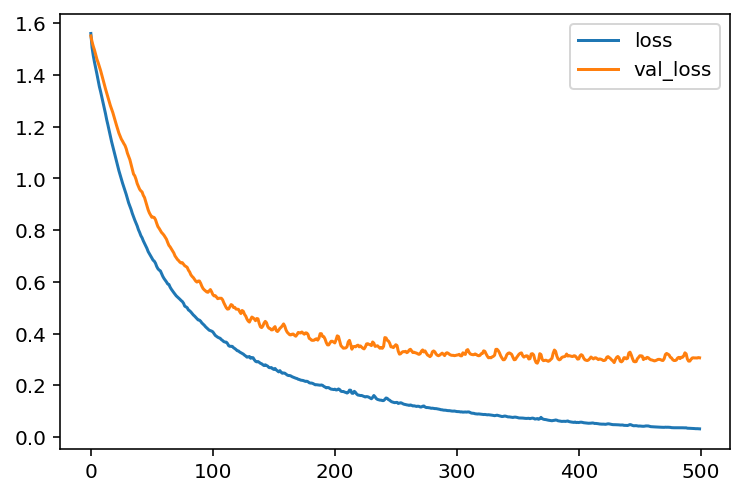

In [26]:
utils.plot_history(emoji_history, ['loss', 'val_loss'])

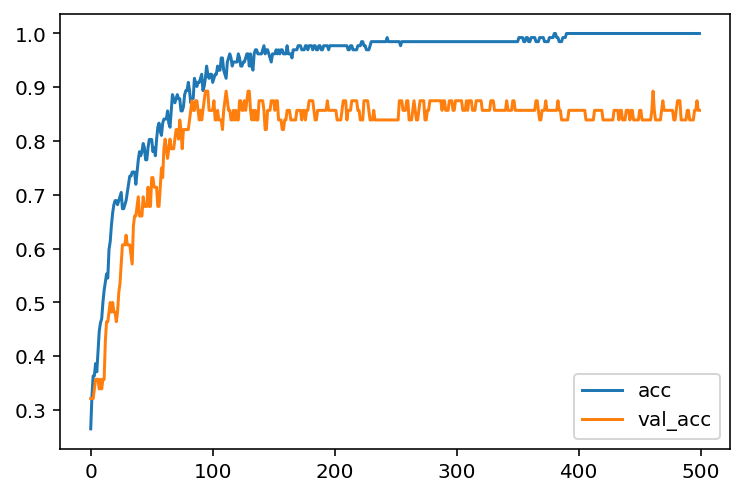

In [27]:
utils.plot_history(emoji_history, ['acc', 'val_acc'])

In [28]:
results = emoji_model.evaluate(train_x, train_y_oh, verbose=1)

132/132 [==============================] - ETA: 0s - loss: 0.0429 - acc: 1.000 - 0s 45us/sample - loss: 0.0316 - acc: 1.0000


In [29]:
print ('Train loss, acc:', results)

Train loss, acc: [0.03158403498431047, 1.0]


In [30]:
emoji_model.evaluate(test_x, test_y_oh)

56/56 [==============================] - ETA: 0s - loss: 0.3146 - acc: 0.843 - 0s 71us/sample - loss: 0.3062 - acc: 0.8571


[0.3062172659805843, 0.85714287]

In [31]:
def pred_emoji(text):
    embedding = np.array([utils.sentence_to_avg(text, word_to_vec_map)]) # get embedding
    pred = emoji_model.predict([embedding]) # predict, return the probability of each class
    label = np.argmax(pred) # choose the one with largest probability as label
    return utils.label_to_emoji(label)

In [53]:
pred_emoji('i am not feeling great')

'😄'